In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
data = pd.read_csv("fer2013.csv")

In [5]:
#check the number of images and each image data variable
data.shape

(35887, 3)

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
np.unique(data["Usage"].values.ravel())

array(['PrivateTest', 'PublicTest', 'Training'], dtype=object)

In [9]:
print ('The number of training data set is %d'%(len(data[data.Usage == "Training"])))

The number of training data set is 28709


In [10]:
train_data = data[data.Usage == "Training"]

In [11]:
pixels_values = train_data.pixels.str.split(" ").tolist()

In [12]:
pixels_values = pd.DataFrame(pixels_values, dtype=int)

In [13]:
images = pixels_values.values

In [14]:
images = images.astype(np.float)

In [15]:
images

array([[  70.,   80.,   82., ...,  106.,  109.,   82.],
       [ 151.,  150.,  147., ...,  193.,  183.,  184.],
       [ 231.,  212.,  156., ...,   88.,  110.,  152.],
       ..., 
       [  74.,   81.,   87., ...,  188.,  187.,  187.],
       [ 222.,  227.,  203., ...,  136.,  136.,  134.],
       [ 195.,  199.,  205., ...,    6.,   15.,   38.]])

In [16]:
#Define a function to show image through 48*48 pixels
def show(img):
    show_image = img.reshape(48,48)
    
    #plt.imshow(show_image, cmap=cm.binary)
    plt.imshow(show_image, cmap='gray')

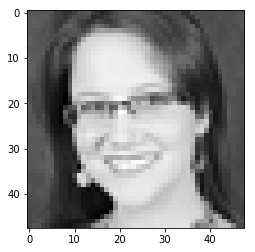

In [19]:
#show one image
show(images[7])

# Pre-processing

In [20]:
images = images - images.mean(axis=1).reshape(-1,1)

In [21]:
images = np.multiply(images,100.0/255.0)

In [22]:
each_pixel_mean = images.mean(axis=0)

In [23]:
each_pixel_std = np.std(images, axis=0)

In [24]:
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)

In [25]:
images.shape

(28709, 2304)

In [27]:
image_pixels = images.shape[1]
print ('Flat pixel values is %d'%(image_pixels))

Flat pixel values is 2304


In [28]:
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)

In [29]:
image_width

48

In [30]:
labels_flat = train_data["emotion"].values.ravel()

In [31]:
labels_count = np.unique(labels_flat).shape[0]

In [32]:
print ('The number of different facial expressions is %d'%labels_count)

The number of different facial expressions is 7


In [33]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [34]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [35]:
labels[0]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [36]:
VALIDATION_SIZE = 1709

In [37]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

In [38]:
print ('The number of final training data: %d'%(len(train_images)))

The number of final training data: 27000


# Tensorflow CNN

In [39]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [40]:
# convolution
def conv2d(x, W, padd):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padd)

In [41]:
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

In [42]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_pixels])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [43]:
# first convolutional layer 64
W_conv1 = weight_variable([5, 5, 1, 64])
b_conv1 = bias_variable([64])

# (27000, 2304) => (27000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(27000,48,48,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1, "SAME") + b_conv1)
#print (h_conv1.get_shape()) # => (27000,48,48,64)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (27000,24,24,1)
h_norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

In [44]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 64, 128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_norm1, W_conv2, "SAME") + b_conv2)
#print (h_conv2.get_shape()) # => (27000,24,24,128)

h_norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

h_pool2 = max_pool_2x2(h_norm2)

In [45]:
# local layer weight initialization
def local_weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.04)
    return tf.Variable(initial)

def local_bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

In [46]:
# densely connected layer local 3
W_fc1 = local_weight_variable([12 * 12 * 128, 3072])
b_fc1 = local_bias_variable([3072])

# (27000, 12, 12, 128) => (27000, 12 * 12 * 128)
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 128])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (27000, 1024)

In [47]:
# densely connected layer local 4
W_fc2 = local_weight_variable([3072, 1536])
b_fc2 = local_bias_variable([1536])

# (40000, 7, 7, 64) => (40000, 3136)
h_fc2_flat = tf.reshape(h_fc1, [-1, 3072])

h_fc2 = tf.nn.relu(tf.matmul(h_fc2_flat, W_fc2) + b_fc2)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [48]:
# dropout
keep_prob = tf.placeholder('float')
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [50]:
# readout layer for deep net
W_fc3 = weight_variable([1536, labels_count])
b_fc3 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

#print (y.get_shape())

In [51]:
LEARNING_RATE = 1e-4

In [52]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [54]:
 #prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [55]:
TRAINING_ITERATIONS = 3000
    
DROPOUT = 0.5
BATCH_SIZE = 50

In [56]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [57]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [58]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

In [59]:
for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i and display_step<100:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.00 / 0.00 for step 0
training_accuracy / validation_accuracy => 0.12 / 0.22 for step 1
training_accuracy / validation_accuracy => 0.14 / 0.18 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.32 / 0.24 for step 4
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 5
training_accuracy / validation_accuracy => 0.22 / 0.24 for step 6
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 7
training_accuracy / validation_accuracy => 0.26 / 0.24 for step 8
training_accuracy / validation_accuracy => 0.26 / 0.24 for step 9
training_accuracy / validation_accuracy => 0.22 / 0.24 for step 10
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 20
training_accuracy / validation_accuracy => 0.32 / 0.24 for step 30
training_accuracy / validation_accuracy => 0.24 / 0.24 for step 40
training_accuracy / validation_accuracy => 0.14 / 0.24 for step 50
train

In [60]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

validation_accuracy => 0.5260


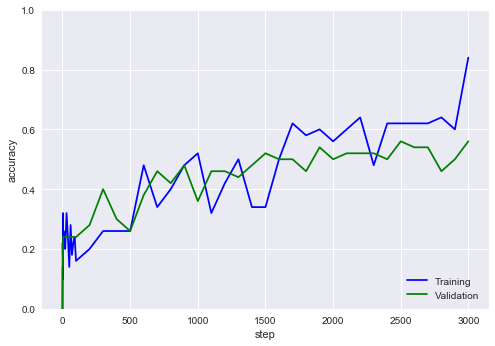

In [61]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.0, ymin = 0.0)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [62]:
saver = tf.train.Saver(tf.all_variables())

Instructions for updating:
Please use tf.global_variables instead.


In [64]:
# read test data from CSV file 
test_data = data[data.Usage == "PublicTest"]

In [65]:
test_data.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [66]:
len(test_data)

3589

In [67]:
test_pixels_values = test_data.pixels.str.split(" ").tolist()

In [68]:
test_pixels_values = pd.DataFrame(test_pixels_values, dtype=int)

In [69]:
test_images = test_pixels_values.values

In [70]:
test_images = test_images.astype(np.float)

In [71]:
test_images = test_images - test_images.mean(axis=1).reshape(-1,1)
test_images = np.multiply(test_images,100.0/255.0)

In [72]:
test_images = np.divide(np.subtract(test_images,each_pixel_mean), each_pixel_std)

In [73]:
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])

test_images(3589,2304)


In [74]:
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

predicted_lables(3589)


In [75]:
predicted_lables

array([ 0.,  4.,  0., ...,  0.,  0.,  0.])

In [76]:
test_data.emotion.values

array([0, 1, 4, ..., 4, 4, 4], dtype=int64)

In [77]:
accuracy_score(test_data.emotion.values, predicted_lables)

0.52131512956255222

In [78]:
confusion_matrix(test_data.emotion.values, predicted_lables)

array([[211,   4,  23,  53,  71,  10,  95],
       [ 15,  17,   3,   3,  12,   0,   6],
       [ 66,   1, 139,  47,  97,  35, 111],
       [ 48,   0,  19, 637,  58,  16, 117],
       [104,   0,  37,  89, 241,  10, 172],
       [ 26,   1,  34,  30,  17, 266,  41],
       [ 65,   0,  18,  65,  91,   8, 360]])

In [79]:
cnf_matrix = confusion_matrix(test_data.emotion.values, predicted_lables)

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Confusion matrix, without normalization
[[211   4  23  53  71  10  95]
 [ 15  17   3   3  12   0   6]
 [ 66   1 139  47  97  35 111]
 [ 48   0  19 637  58  16 117]
 [104   0  37  89 241  10 172]
 [ 26   1  34  30  17 266  41]
 [ 65   0  18  65  91   8 360]]


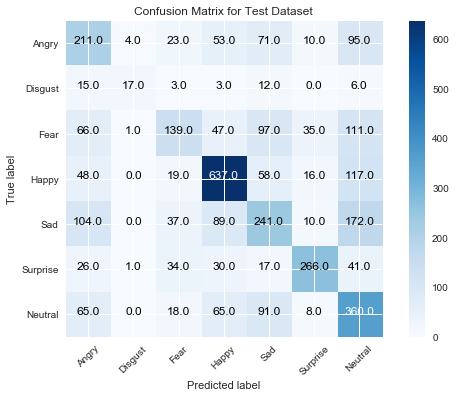

In [82]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion Matrix for Test Dataset')

plt.show()